<a href="https://colab.research.google.com/github/dottorm/styleganv2/blob/main/tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\Drive/tesi

Mounted at /content/drive
/content/drive/MyDrive/tesi


In [3]:
#!git clone https://github.com/AmarSaini/Epoching_StyleGan2_Setup.git

Cloning into 'Epoching_StyleGan2_Setup'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 10), reused 93 (delta 6), pack-reused 0
Receiving objects: 100% (106/106), 3.81 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
#import shutil
#from pathlib import Path

#repo_root = Path('Epoching_StyleGan2_Setup/')

# Pull contents out of the repo, into our current directory.
#for content in repo_root.iterdir():
#    shutil.move(str(content), '.')

In [5]:
!pip install requests
!pip install Pillow
!pip install tqdm
!pip install dlib

In [6]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [8]:
import sys
sys.path.append('stylegan2/')
from stylegan2 import pretrained_networks
from stylegan2 import dnnlib
from stylegan2.dnnlib import tflib
from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm
model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
fps = 20
results_size = 400

In [9]:
# Code to load the StyleGAN2 Model
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

# Generate images given a random seed (Integer)
def generate_image_random(rand_seed):
    rnd = np.random.RandomState(rand_seed)
    z = rnd.randn(1, *Gs.input_shape[1:])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
    images = Gs.run(z, None, **Gs_kwargs)
    return images, z

# Generate images given a latent code ( vector of size [1, 512] )
def generate_image_from_z(z):
    images = Gs.run(z, None, **Gs_kwargs)
    return images


In [10]:
Gs, noise_vars, Gs_kwargs = load_model()

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [13]:
images, latent_code1 = generate_image_random(11)
image1 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code1.shape

(1, 512)

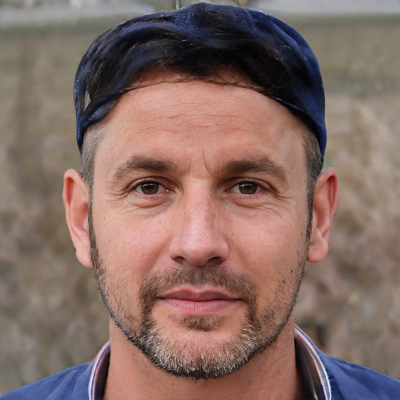

In [14]:
image1

In [21]:
images, latent_code2 = generate_image_random(88)
image2 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code2.shape

(1, 512)

In [22]:
latent_code1[0][:5], latent_code2[0][:5]

(array([ 1.74945474, -0.286073  , -0.48456513, -2.65331856, -0.00828463]),
 array([0.1068843 , 2.20581524, 0.95656269, 0.0684111 , 1.06851382]))

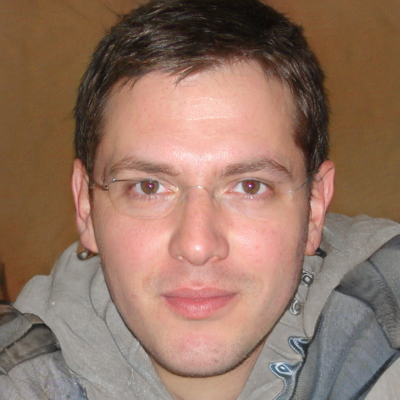

In [23]:
image2

In [24]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

In [25]:
interpolated_latent_code = linear_interpolate(latent_code1, latent_code2, 0.5)
interpolated_latent_code.shape

(1, 512)

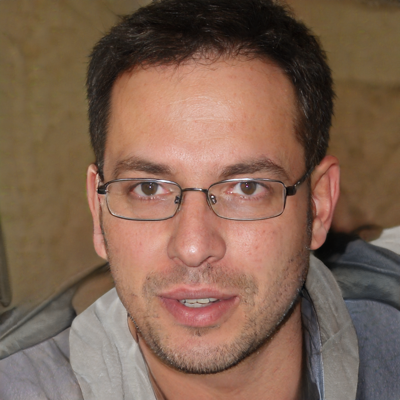

In [26]:
images = generate_image_from_z(interpolated_latent_code)
Image.fromarray(images[0]).resize((results_size, results_size))

In [27]:
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()

In [28]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_latent_interp_animation(code1, code2, img1, img2, num_interps):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_z(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((400, 400))
        frame = get_concat_h(img1, interp_latent_image)
        frame = get_concat_h(frame, img2)
        all_imgs.append(frame)

    save_name = output_gifs_path/'latent_space_traversal.gif'
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)



In [29]:
make_latent_interp_animation(latent_code1, latent_code2, image1, image2, num_interps=200)

100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


In [30]:
orig_img_path = Path('imgs')
aligned_imgs_path = Path('aligned_imgs')

# Make Aligned Images folder if it doesn't exist.
if not aligned_imgs_path.exists():
    aligned_imgs_path.mkdir()
    
orig_img_path, aligned_imgs_path

(PosixPath('imgs'), PosixPath('aligned_imgs'))

In [31]:
if not Path('shape_predictor_68_face_landmarks.dat').exists():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dv shape_predictor_68_face_landmarks.dat.bz2

--2021-10-12 19:08:01--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  37.5MB/s    in 1.6s    

2021-10-12 19:08:03 (37.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

  shape_predictor_68_face_landmarks.dat.bz2: done


In [32]:
from align_face import align_face

# Align all of our images using a landmark detection model!
all_imgs = list(orig_img_path.iterdir())
for img in all_imgs:
    align_face(str(img)).save(aligned_imgs_path/('aligned_'+img.name))

Number of faces detected: 1
Detection 0: Left: 375 Top: 333 Right: 760 Bottom: 718
Part 0: (377, 509), Part 1: (390, 552) ...
Number of faces detected: 1
Detection 0: Left: 1224 Top: 514 Right: 2022 Bottom: 1313
Part 0: (1338, 662), Part 1: (1326, 759) ...


In [34]:
aligned_img_set = list(aligned_imgs_path.iterdir())
aligned_img_set.sort()
aligned_img_set = [Image.open(x) for x in aligned_img_set]

orig_img_set = list(orig_img_path.iterdir())
orig_img_set.sort()
orig_img_set = [Image.open(x) for x in orig_img_set]

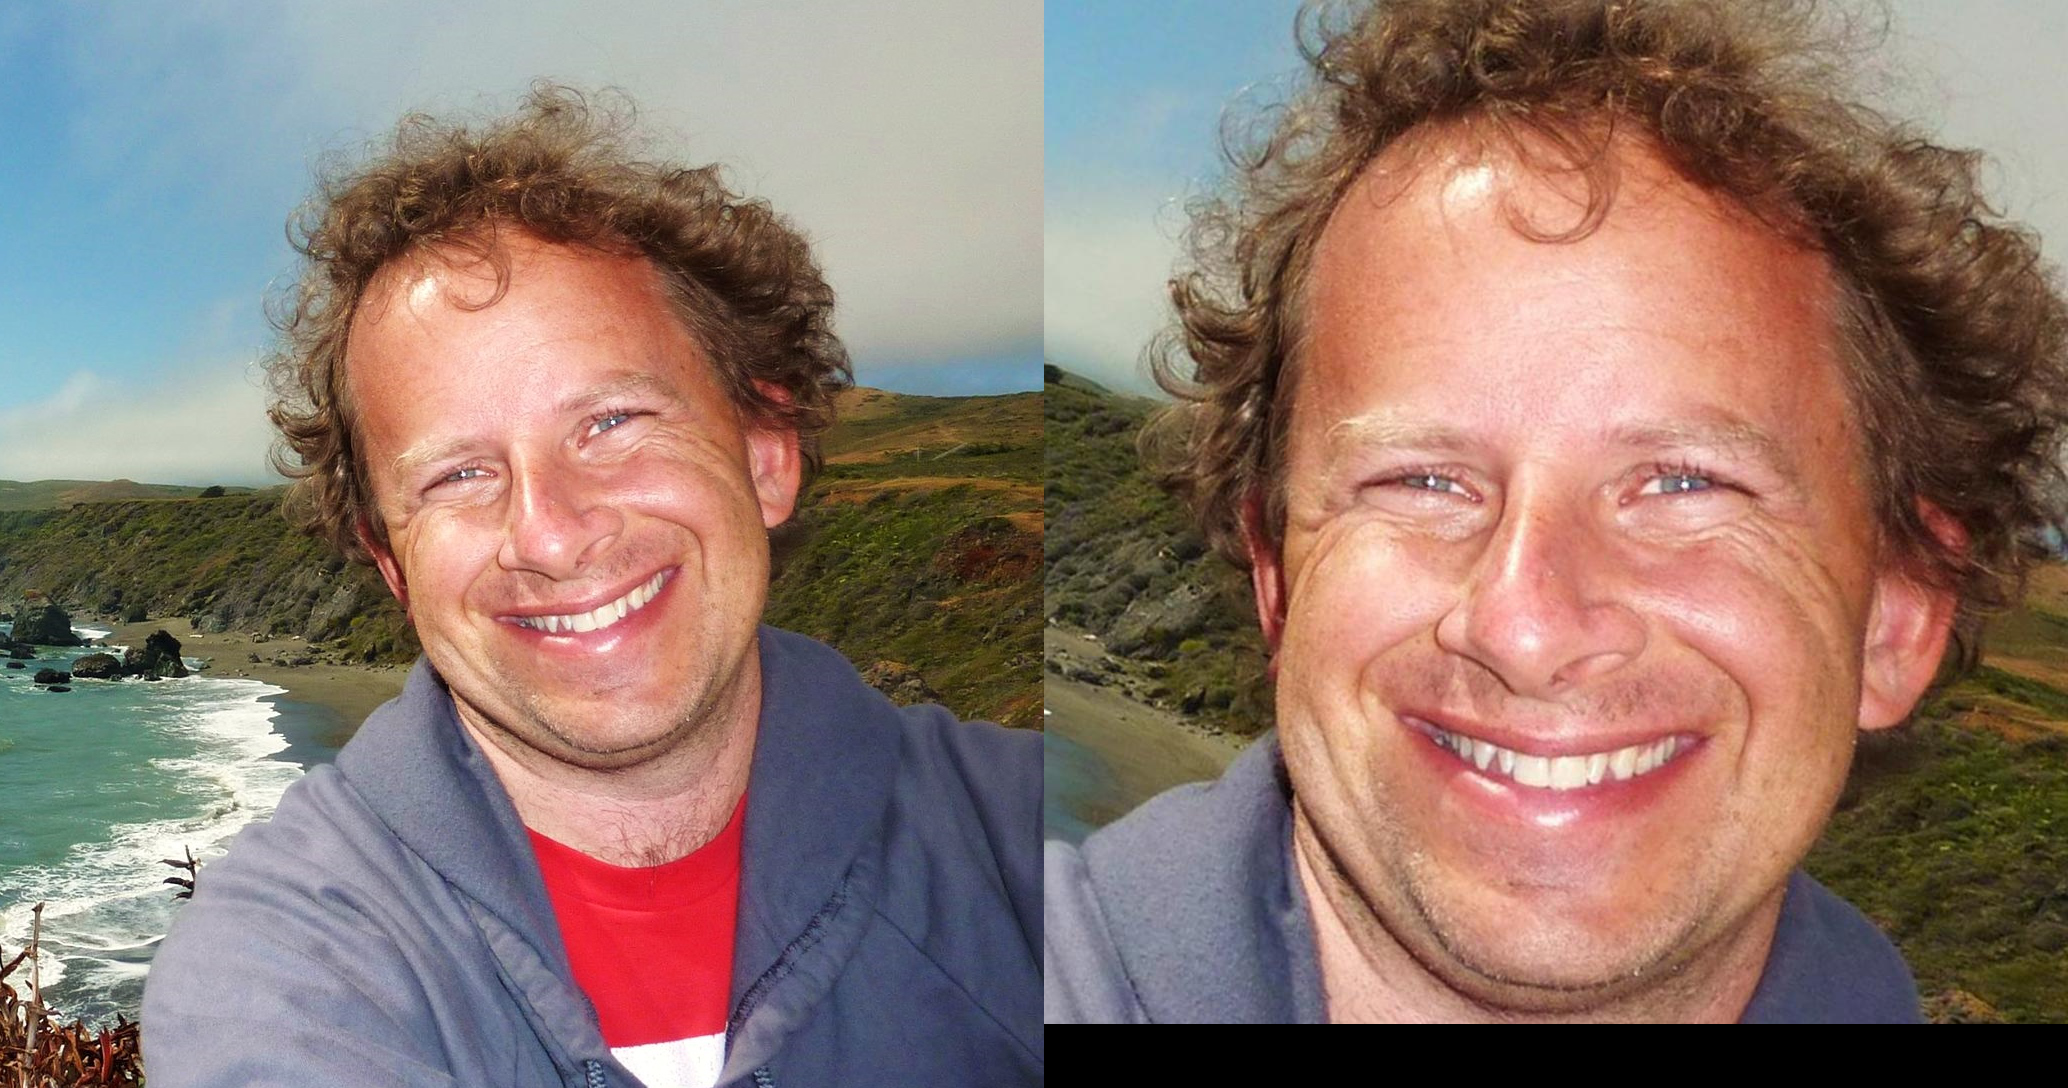

In [35]:
get_concat_h(orig_img_set[0], aligned_img_set[0])

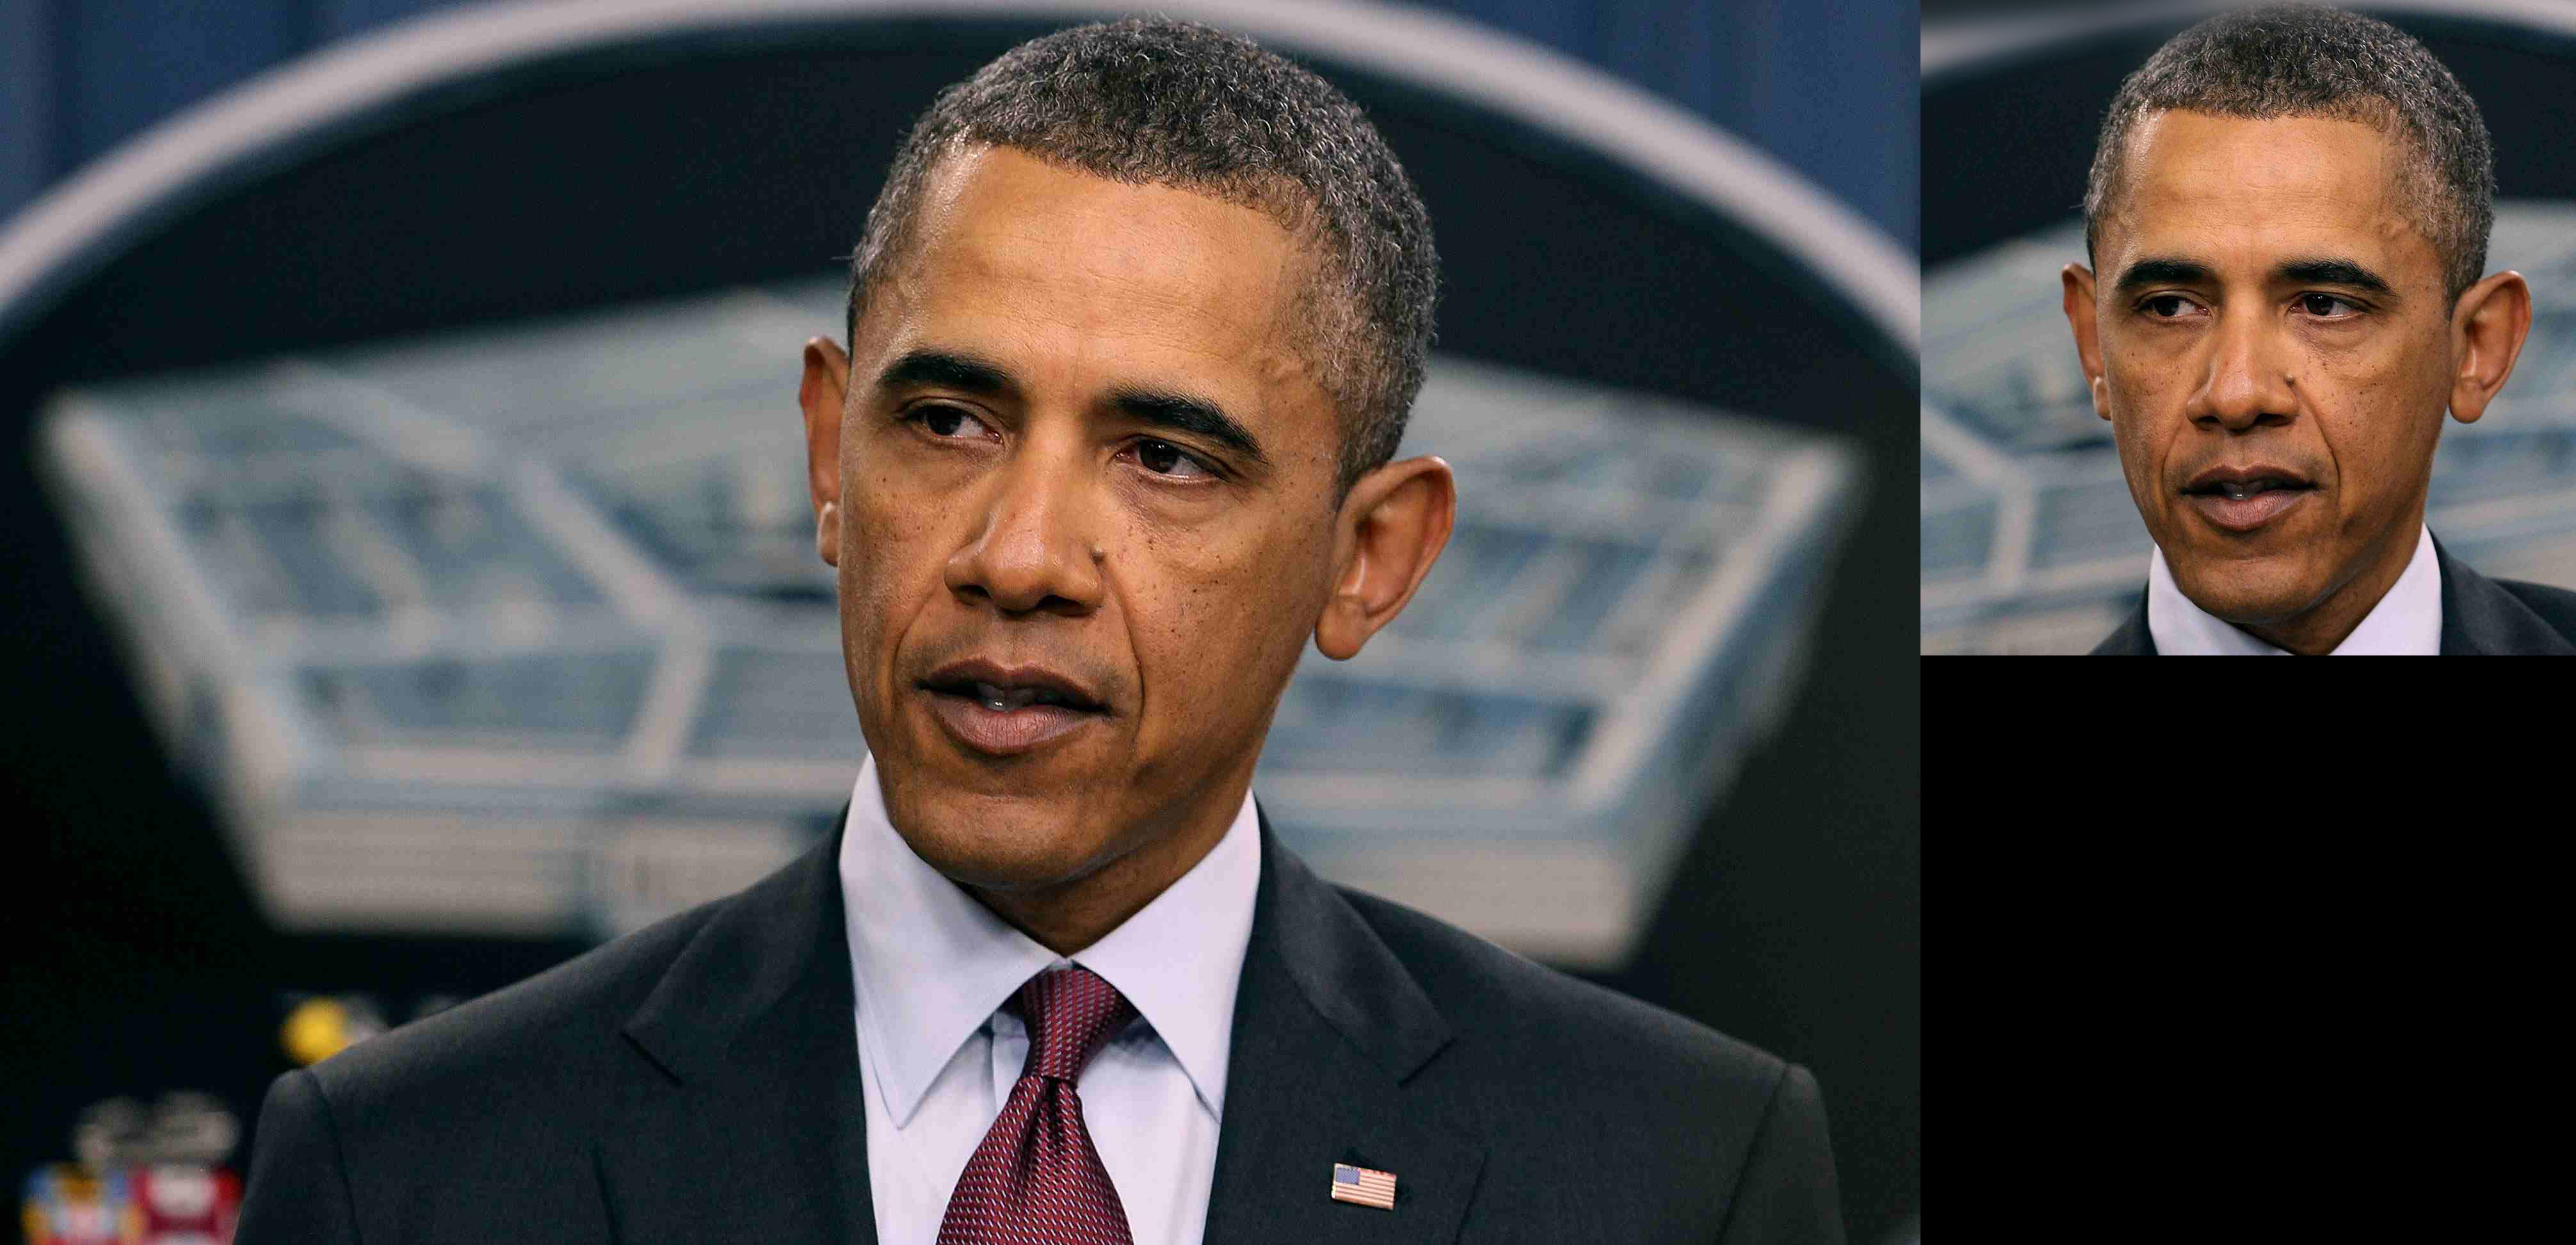

In [36]:
get_concat_h(orig_img_set[1], aligned_img_set[1])

In [37]:
!python -W ignore stylegan2/dataset_tool.py create_from_images datasets_stylegan2/custom_imgs aligned_imgs/

Loading images from "aligned_imgs/"
Creating dataset "datasets_stylegan2/custom_imgs"
Added 2 images.


In [38]:
tot_aligned_imgs = 2

In [39]:
!python -W ignore stylegan2/epoching_custom_run_projector.py project-real-images --network=$model_path \
  --dataset=custom_imgs --data-dir=datasets_stylegan2 --num-images=$tot_aligned_imgs --num-snapshots 500

Local submit - run_dir: results/00000-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from "custom_imgs"...
tcmalloc: large alloc 4294967296 bytes == 0x5563a8fac000 @  0x7f00098a0001 0x7f000741e54f 0x7f000746eb58 0x7f0007472b17 0x7f0007511203 0x55636f95d544 0x55636f95d240 0x55636f9d1627 0x55636f9cbced 0x55636f95f48c 0x55636f9a0159 0x55636f99d0a4 0x55636f95f698 0x55636f9cdfe4 0x55636f9cb9ee 0x55636f95ebda 0x55636f9cd737 0x55636f9cb9ee 0x55636f89de2b 0x55636f9cdfe4 0x55636f95eafa 0x55636f9cc915 0x55636f95eafa 0x55636f9ccc0d 0x55636f9cb9ee 0x55636f89de2b 0x55636f9cdfe4 0x55636f95eafa 0x55636f9cc915 0x55636f9cb9ee 0x55636f9cb6f3
tcmalloc: large alloc 4294967296 bytes == 0x5564a8fac000 @  0x7f000989e1e7 0x

In [41]:
def get_control_latent_vectors(path):
    files = [x for x in Path(path).iterdir() if str(x).endswith('.npy')]
    latent_vectors = {f.name[:-4]:np.load(f) for f in files}
    return latent_vectors
    
latent_controls = get_control_latent_vectors('stylegan2directions/')
len(latent_controls), latent_controls.keys(), latent_controls['age'].shape

(16,
 dict_keys(['age', 'eye_distance', 'eye_eyebrow_distance', 'eye_ratio', 'eyes_open', 'gender', 'lip_ratio', 'mouth_open', 'mouth_ratio', 'nose_mouth_distance', 'nose_ratio', 'nose_tip', 'pitch', 'roll', 'smile', 'yaw']),
 (18, 512))